# Name: Ronald Macmaster (eid: rpm953)
# Kaggle Name: ronny.macmaster (macmaster)
## Public Leaderboard Rank: 9th
## Private Leaderboard Rank: 4th

In [11]:
# stack.py
# model for the kaggle competition
# author: Ronny Macmaster

import custom # custom function library
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

mpl.style.use(["fivethirtyeight"])
sns.set(style="whitegrid", color_codes=True)


# Peliminary Data Preprocessing

Load the training and test data.   
Perform some feature selection.  
F26 is a highly collinear feature, and including it barely lowers the cross validation score.  
The others were selected throughout various runs of RandomForests   
and XGBClassifiers and examining the feature_importances_ attribute of such trained models. 

## Scaling and Imputing the Data
A lot of different scaling schemes were tried.   
boxcox is a nice way to unskew a distribution when simple logging or sqrting fails.  
However, neither robust scaling nor boxcox scaling seemed to significantly impact the cross validation score.  
In the end, simple variance normalization seemed to work the best.  
This approach helps with regularization and allows training of neural networks.  
Imputing with the median seems to provide the nicest distribution shapes.  

## Optional Exploratory Data Analysis
When developing the original models, I did A LOT of exploratory data analysis.  
Not all of it can be presented here, because doing do would severly clutter the report.  
However, some of the EDA will be pressented at the end of the report.  



In [12]:
train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")
data = pd.concat([train, test]) # all data
data.drop(["Y"], axis=1, inplace=True)

# drop some collinear features
data.drop(["F26"], axis=1, inplace=True)

# junk features
data.drop(["F4", "F7", "F8", "F15", "F17", "F20", "F24"], axis=1, inplace=True)
data.drop(["F1", "F12", "F13"], axis=1, inplace=True) # further random forest selection
data.drop(["F9", "F21"], axis=1, inplace=True) # round 2 forest selection
# data.drop(["F9", "F16", "F21"], axis=1, inplace=True) # round 2 forest selection

# scale some features with boxcox 
from scipy.stats import skew, boxcox
from sklearn.preprocessing import scale, robust_scale, minmax_scale
data.fillna(data.median(), inplace=True)

# data transformations
data["F6"] = np.log(data["F6"])
data["F16"] = np.log(data["F16"])
data = data.apply(scale)

print "data post processing: ", data.shape
print "features:", data.columns
xtest = data[train.shape[0]:]
xtrain = data[:train.shape[0]]
ytrain = train["Y"]

# optional EDA
# custom.eda_countplot(xtrain, ytrain)
# custom.eda_heatmap(xtrain)
# custom.eda_boxplot(xtrain, ytrain)


data post processing:  (99998, 14)
features: Index([u'F10', u'F11', u'F14', u'F16', u'F18', u'F19', u'F2', u'F22', u'F23',
       u'F25', u'F27', u'F3', u'F5', u'F6'],
      dtype='object')


/home/ronny/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


# Train some Basic Forest Models and a Neural Network
We can get a feel for  how well we've prepared the data by training simple models first.  
These forest models can achieve a cross validation score in the range of 0.856 to 0.859.  
The neural network, MLPClassifier, is a hail mary that performs suprisingly well out of the box.  
It achieves a cross validation score in the 0.858 range as well.  

The Naive bayes classifier can perform well with the data straight out of the box,  
but performing a lot of feature selection and preprocessing seems to lower its performance.  
In the end, its low CV score eliminates it from consideration as a  base stack model.  
The story is similar for the K nearest neighbors model.  

### All of these models will make great candidate for base stacking models later.  


In [13]:
# train a random forest 
# best model params(1800):  {'max_features': 'log2', 'max_leaf_nodes': 300, 'criterion': 'entropy', 'min_samples_leaf': 92}
from sklearn.ensemble import RandomForestClassifier
rforest_clf = RandomForestClassifier( n_jobs = 2,
    n_estimators = 160, criterion="entropy", 
    min_samples_leaf=90, max_leaf_nodes=325,
    oob_score=True, max_features="log2")

# train an extra random forest
# best model params(800):  {'max_features': 'log2', 'max_leaf_nodes': 400, 'criterion': 'entropy', 'min_samples_leaf': 12}
from sklearn.ensemble import ExtraTreesClassifier
eforest_clf = ExtraTreesClassifier( n_jobs = 2,
    n_estimators = 160, criterion="entropy",
    min_samples_leaf=8, max_leaf_nodes=560,
    # min_samples_leaf=3, max_leaf_nodes=425, # interaction features
    max_features="log2")

# train a neural network
from sklearn.neural_network import MLPClassifier
neural_clf = MLPClassifier()
# best gen model params:  {'alpha': 0.01, 'activation': 'relu', 'hidden_layer_sizes': (36,)}

# train a native bayes classifier
from sklearn.naive_bayes import GaussianNB
gaussian_clf = GaussianNB()

# train a K nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=2, n_neighbors=300)


# Train an XGBoost Model (or three)
Train an XG boost model to perform classification.  
All of these models were tuned using the grid search CV snippets below.  
Interestingly, optimizing XGB models with different tree depths can make for a collection of heterogeneous classifiers.  
In the end, the combination of these three XGB classifiers (with slightly different hyperparameters) makes for a very powerful stack base.  
Alone, they achieve cross validation scores in the 0.860 to 0.862 range.  

In [14]:
# train an xgboost model
# {'colsample_bytree': 0.7, 'scale_pos_weight': 1, 'learning_rate': 0.05, 'min_child_weight': 3, 'n_estimators': 160, 'subsample': 0.7, 'max_depth': 4, 'gamma': 0 
import xgboost as xgb
import random
xgb_clf = xgb.XGBClassifier( nthread = 2,
    n_estimators = 515, max_depth=4,
    learning_rate=0.02, gamma=0.37,
    min_child_weight=2.4, scale_pos_weight=1,
    subsample=0.76, colsample_bytree=0.58,
    reg_alpha=4.5, seed=random.randint(0, 50),    
#     n_estimators = 515, max_depth=4,
#     learning_rate=0.02, gamma=0.37,
#     min_child_weight=2.35, scale_pos_weight=0.95,
#     subsample=0.72, colsample_bytree=0.58,
#     reg_alpha=4.5, seed=random.randint(0, 50),
)
xgb1_clf = xgb.XGBClassifier( nthread = 2,
    n_estimators = 915, max_depth=3,
    learning_rate=0.02, gamma=1.2,
    min_child_weight=2, scale_pos_weight=0.9,
    subsample=0.65, colsample_bytree=0.6,
    reg_alpha=4.5, seed=random.randint(0, 50),
#     n_estimators = 915, max_depth=3,
#     learning_rate=0.02, gamma=1.05,
#     min_child_weight=2, scale_pos_weight=1,
#     subsample=0.6, colsample_bytree=0.6,
#     reg_alpha=1, seed=random.randint(0, 50),
)
xgb2_clf = xgb.XGBClassifier( nthread = 2,
    n_estimators = 550, max_depth=5,
    learning_rate=0.02, gamma=1.3,
    min_child_weight=2, scale_pos_weight=1,
    subsample=0.66, colsample_bytree=0.65,
    reg_alpha=7.25, seed=random.randint(0, 50),
#     n_estimators = 450, max_depth=5,
#     learning_rate=0.03, gamma=0.9,
#     min_child_weight=2.2, scale_pos_weight=1,
#     subsample=0.66, colsample_bytree=0.6,
#     reg_alpha=2.4, seed=random.randint(0, 50),
)


Random Forest Feature Importances:
F16    0.006898
F5     0.007815
F6     0.013142
F10    0.014632
F11    0.014855
F22    0.027669
F19    0.029410
F27    0.035317
F18    0.045073
F2     0.088068
F25    0.141493
F3     0.150775
F14    0.211526
F23    0.213327
dtype: float64
Random Forest oob score:  0.934657386295 

Extra Random Forest Feature Importances:
F27    0.005437
F16    0.009769
F19    0.010417
F6     0.011964
F5     0.020165
F10    0.020644
F11    0.020918
F22    0.028160
F3     0.033070
F23    0.038442
F18    0.107147
F2     0.175212
F25    0.227826
F14    0.272079
dtype: float64 

XGB Feature Importances:
F16    0.024227
F5     0.029072
F6     0.045319
F10    0.050306
F11    0.053014
F2     0.058857
F14    0.062705
F25    0.075246
F22    0.084937
F18    0.090067
F3     0.095055
F19    0.098760
F23    0.114151
F27    0.118284
dtype: float32 



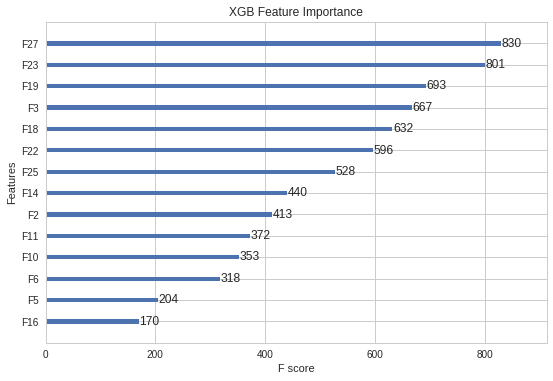

In [19]:
# rforest_clf.fit(xtrain, ytrain)
rforest_clf.fit(xtrain, ytrain)
importances = pd.Series(rforest_clf.feature_importances_, index=xtrain.columns.values)
print "Random Forest Feature Importances:\n", importances.sort_values()
print "Random Forest oob score: ", rforest_clf.oob_score_, "\n"

# eforest_clf.fit(xtrain, ytrain)
eforest_clf.fit(xtrain, ytrain)
importances = pd.Series(eforest_clf.feature_importances_, index=xtrain.columns.values)
print "Extra Random Forest Feature Importances:\n", importances.sort_values(), "\n"


# plot xgb feature importance
# xgb feature selection
xgb_clf = xgb_clf.fit(xtrain, ytrain, eval_metric="auc")
importances = pd.Series(xgb_clf.feature_importances_, index=xtrain.columns.values)
print "XGB Feature Importances:\n", importances.sort_values(), "\n"
xgb.plot_importance(xgb_clf)
plt.title("XGB Feature Importance") 
plt.show(); plt.close()


# Stacking Model
Here, I experimented with stacking different models.  
Most of the time,  stacking actually led to a degredation in performance.  
If the base models are relatively correlated and / or far apart in performance,  
Multiple models could possibly degrade the performance of a single model.  

In the end, what worked best was three xgboost classifiers as the base of the stack.  
and a neural network (MLP) classifier as the level 1 generalizer.  
The optimal model used a multi layer perceptron generalizer with two hidden layers, each of size 110.  

I think that using a keras neural network may have provided better results.  
However, I ran out of time and computinh resources to train and try out many different combinations.  
Some of the keras neural nets are presented below.  


## Finding the right generalizer  
Training an entire stack is slow.  
If there are 7 folds and three base models, each base model needs to be trained 7 times.  
Thus, it can about 21x longer to train the entire stack in comparison to a single xgboost model.  
Performing cross validation on such a model is an even bigger nightmare.  

One strategy is to experiment with different generalizers on a new data set of predictions from the base models.  
I generated a "level1.csv" data set of prediction probabilites from the base models and tried to see which generalizers may work better than a simple logistic regression generalizer.  
Neural networks seemed to work well here.  

In [20]:
###### Forest Stack
# run a stacking generalization over the 2 forest models
from sklearn.linear_model import LogisticRegression
from custom import StackedClassifier, ExtraStackedClassifier
# stack_gen = LogisticRegression(penalty="l2")

# old from tuesday.
# best gen model params:  {'alpha': 1, 'activation': 'logistic', 'batch_size': 80, 'hidden_layer_sizes': (110, 110)}
# best gen model cv score:  0.862517037271

# generalizer 1: level1 cv error:
stack1_gen = MLPClassifier(hidden_layer_sizes=(36,18), 
    activation="relu", alpha=0.02, batch_size=100)

# # generalizer 2: level1 cv error: 0.8624
stack2_gen = xgb.XGBClassifier( nthread = 2,
    n_estimators = 215, max_depth=2,
    learning_rate=0.02, gamma=0.07,
    min_child_weight=0.25, scale_pos_weight=1.05,
    subsample=0.7, colsample_bytree=0.52,
    reg_alpha=0.02, seed=random.randint(0, 50),    
)

# stack_clf = StackedClassifier(clfs=[xgb_clf, eforest_clf, gaussian_clf], gen=stack_gen, folds=5) # simple cv optimal
# stack_clf = StackedClassifier(clfs=[xgb_clf, rforest_clf, eforest_clf], gen=stack_gen, folds=7) # option 2 cv optimal
# stack_clf = StackedClassifier(clfs=[xgb2_clf, rforest_clf, eforest_clf], gen=stack1_gen, folds=7) # option 1 cv optimal
stack_clf = StackedClassifier(clfs=[xgb_clf, xgb1_clf, xgb2_clf], gen=stack1_gen, folds=7) # option 1 cv optimal


# # generate level1 training set. 
# level1x, level1y = stack_clf.level1_set(xtrain, ytrain)
# level1 = pd.DataFrame(level1x)
# level1["y"] = level1y 
# level1.to_csv("level1.csv")

In [22]:
# train a keras neural network (or three)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_auc_score
def create_nn():
    model = Sequential()
    model.add(Dense(3, input_dim=xtrain.shape[1], activation="relu"))
    model.add(Dense(3, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile( # binary classification
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"])
    return model

def create_nn2():
    model = Sequential()
    model.add(Dense(4, input_dim=xtrain.shape[1], activation="relu"))
    model.add(Dense(6, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile( # binary classification
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"])
    return model

def create_nn3():
    model = Sequential()
    model.add(Dense(6, input_dim=xtrain.shape[1], activation="relu"))
    model.add(Dense(3, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile( # binary classification
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"])
    return model

keras_clf = KerasClassifier(
    build_fn=create_nn, epochs=800, 
    batch_size=500, verbose=0)

keras2_clf = KerasClassifier(
    build_fn=create_nn, epochs=800, 
    batch_size=500, verbose=0)

keras3_clf = KerasClassifier(
    build_fn=create_nn, epochs=800, 
    batch_size=500, verbose=0)

# Hyper Parameter Optimization (GridSearchCV)
There are many models that need to be optimized.  
Some have more hyper parameters than others.  
Here is a collection of SOME (not all) of the grid searches I used to optimize hyperparmeters.  
These take a very long time to execute.  


In [24]:
from sklearn.model_selection import GridSearchCV
stack_grid = {
    "clfs" : [
        [xgb_clf, xgb1_clf, xgb2_clf],
        [xgb_clf, rforest_clf, eforest_clf], # works extremely well with neural net generalizer
        # [xgb1_clf, xgb2_clf, eforest_clf],
        # [xgb1_clf, xgb2_clf, rforest_clf],
        # [xgb1_clf, rforest_clf, eforest_clf],
        [xgb2_clf, rforest_clf, eforest_clf], 
    ],
    "gen" : [stack1_gen, stack2_gen],
    "folds" : [7],
}
# grid_search = GridSearchCV(stack_clf, stack_grid, cv=7, verbose=1500, scoring="roc_auc")
# grid_search.fit(xtrain, ytrain)
# print "best stack model params: ", grid_search.best_params_
# print "best stack model cv score: ", grid_search.best_score_

xgb_params = {
    "learning_rate" : 0.02,
    "max_depth" : 5,
    "gamma" : 1.3,
    "subsample" : 0.66,
    "colsample_bytree" : 0.65,
    "min_child_weight" : 2,
    "scale_pos_weight" : 1,
    "reg_alpha" : 7.25
}

# # built in cv for n estimators
# xgtrain = xgb.DMatrix(xtrain.values, label=ytrain.values)
# cvresult = xgb.cv(xgb_params, xgtrain, verbose_eval=False, 
#     num_boost_round=3000, nfold=5, stratified=True, metrics="auc",
#     early_stopping_rounds=100,)
# print "xgb.cv result: ", cvresult.sort_values(by="test-auc-mean")

from sklearn.model_selection import GridSearchCV
xgb_grid = {
    "n_estimators" : [500, 550, 600], # 1200 for 0.01
    "learning_rate" : [0.02, 0.03],
    "max_depth" : [5],
    "gamma" : [1.3],
    "min_child_weight" : [2],
    "scale_pos_weight" : [1],
    "subsample" : [0.66],
    "colsample_bytree" : [0.65],
    "reg_alpha" : [7.25], # 1.1
}

# grid_search = GridSearchCV(xgb2_clf, xgb_grid, cv=12, verbose=5000, scoring="roc_auc")
# grid_search.fit(xtrain, ytrain)
# print "best model params: ", grid_search.best_params_
# print "best model cv score: ", grid_search.best_score_


neural_grid = {
    "hidden_layer_sizes" : [(36,)],
    "activation" : ["logistic", "relu"],
    "alpha" : [0.01, 0.1, 0.5],
    # "batch_size" : [70, 80, 90]
}
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(neural_clf, neural_grid, cv=7, verbose=5000, scoring="roc_auc")
# grid_search = grid_search.fit(xtrain, ytrain)
# print "best gen model params: ", grid_search.best_params_
# print "best gen model cv score: ", grid_search.best_score_

eforest_grid = {
    "min_samples_leaf" : [8],
    # "max_leaf_nodes" : [310, 325, 340],
    "max_leaf_nodes" : [540, 560, 580],
}

# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(eforest_clf, eforest_grid, cv=7, verbose=5000, scoring="roc_auc")
# grid_search.fit(xtrain, ytrain)
# print "best model params: ", grid_search.best_params_
# print "best model cv score: ", grid_search.best_score_

from sklearn.model_selection import GridSearchCV
lr_grid = {
    "C" : [0.001, 0.01, 0.1, 0.5, 1],
    "penalty" : ["l2", "l1"]
}

mlp_grid = {
    "hidden_layer_sizes" : [(36, 18)],
    "activation" : ["relu"],
    "alpha" : [0.02],
    "batch_size" : [100]
}

# grid_search = GridSearchCV(mlp_clf, mlp_grid, cv=10, verbose=1500, scoring="roc_auc")
# grid_search.fit(xtrain.values, ytrain.values)
# print "best model params: ", grid_search.best_params_
# print "best model cv score: ", grid_search.best_score_


# Evaluating Performance  
Evaluating performance can be tricky.  
It requires a lot of iterative cross validation.  
Plotting the training ROC curve can provide a helpful visualization at first,  
but the cross validation score is the most important at the end of the day.  
The submissions are also generated here.  

Most of my early submissions were trained using 5 fold cross validation.  
Toward the end of the competition, I optimized to 12 fold cross validation.  
The model that performs best on 80% of the training data as input   
is not necessarily the model that performs best when fed with 92 % or 100 % of the training data.  
The major downfall to cross validating with more folds is an increase in the cv score variance.  
However, multiple runs of the cv score can be collected to boost confidence about the true mean.  


classifier: XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.65,
       gamma=1.3, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=550, nthread=2,
       objective='binary:logistic', reg_alpha=7.25, reg_lambda=1,
       scale_pos_weight=1, seed=30, silent=True, subsample=0.66)
[CV]  ................................................................
[CV] ........................... , score=0.845288657236, total=  14.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s remaining:    0.0s
[CV]  ................................................................
[CV] ........................... , score=0.854152118784, total=  14.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.2s remaining:    0.0s
[CV]  ................................................................
[CV] ........................... , score=0.867878275571, total=  15.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.

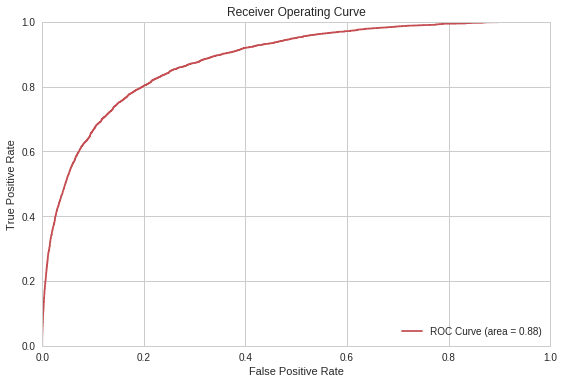

In [25]:
# evaluate performance metrics
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
clf = xgb2_clf # pick a classifier
clf.fit(xtrain, ytrain)
clf_pred = clf.predict_proba(xtrain)[:, 1]
fpr, tpr, thresholds = roc_curve(ytrain, clf_pred)
roc_auc = auc(fpr, tpr)
print "classifier:", clf

# # model metrics and validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=12, verbose=150, scoring="roc_auc")
print "confusion_matrix:\n",confusion_matrix(ytrain, clf.predict(xtrain))
print "stack training set score: ", roc_auc_score(ytrain, clf_pred)
print "cross validation scores:\n", cv_scores
print "cv stats(mean, std): (%f, %f)" % (cv_scores.mean(), cv_scores.std())

# plot the roc curve
custom.roc_plot(fpr, tpr)
plt.show()
plt.close()

# submit solution
submit = pd.DataFrame()
submit["id"] = test.index
submit["Y"] = clf.predict_proba(xtest)[:, 1]
submit.to_csv("stack.csv", index=False)

# Behind the Scenes (EDA and Custom Methods)
Again, a lot of exploratory data analysis was performed.  
Here is a short example of some of the plots used.  
For more information, see custom.py and eda.py (in the old dir)  

count    49998.000000
mean        -0.001007
std          1.009003
min         -0.901724
25%         -0.901724
50%         -0.017976
75%          0.865772
max         46.820679
Name: F10, dtype: float64


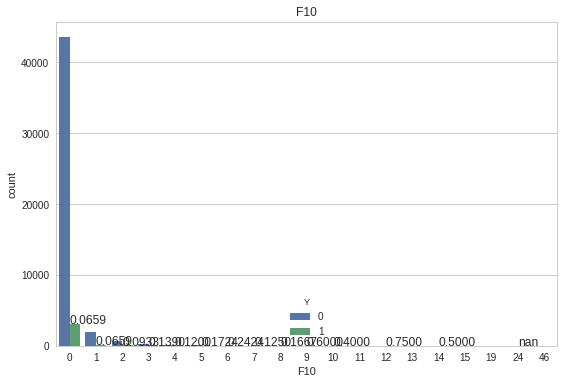

count    49998.000000
mean         0.004403
std          0.997518
min         -4.395486
25%         -0.598520
50%          0.001001
75%          0.600522
max          4.597329
Name: F11, dtype: float64


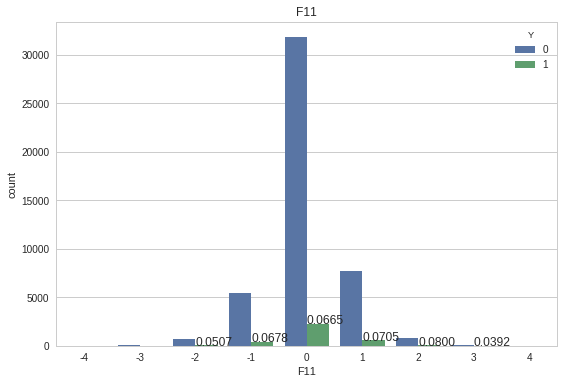

count    49998.000000
mean        -0.000096
std          0.994723
min         -0.063920
25%         -0.063920
50%         -0.063920
75%         -0.063920
max         23.278884
Name: F14, dtype: float64


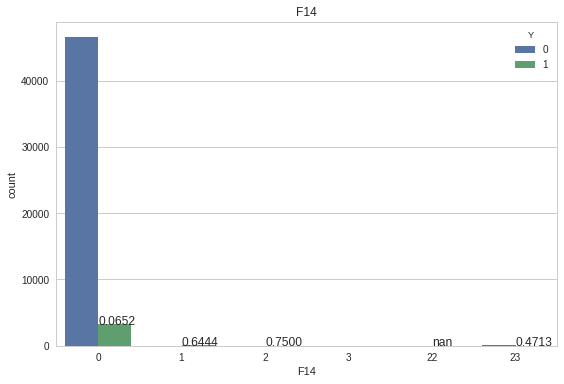

count    49998.000000
mean        -0.003074
std          0.994967
min         -0.604397
25%         -0.604397
50%         -0.604397
75%          0.134006
max          9.957870
Name: F16, dtype: float64


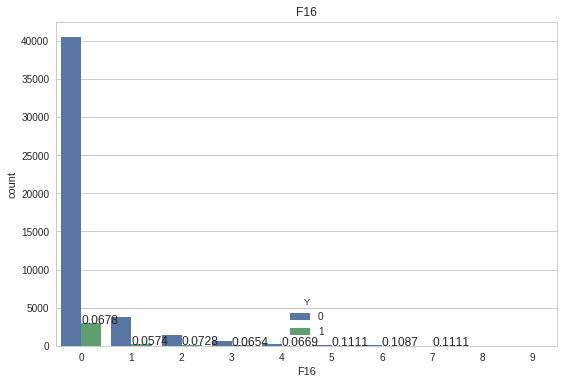

count    49998.000000
mean         0.003496
std          1.002722
min         -2.117861
25%         -0.762631
50%         -0.017254
75%          0.728122
max          3.709627
Name: F18, dtype: float64


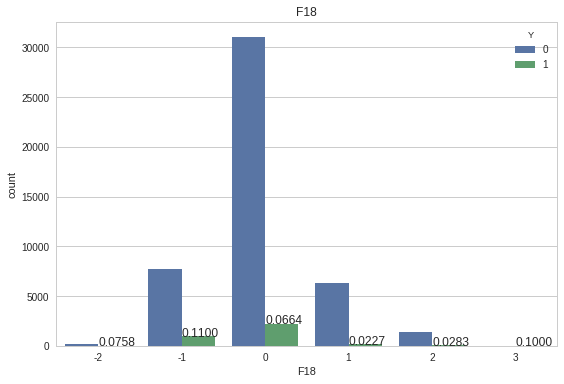

count    49998.000000
mean         0.001800
std          1.282556
min         -0.514313
25%         -0.203669
50%         -0.079958
75%          0.076892
max        241.497699
Name: F19, dtype: float64


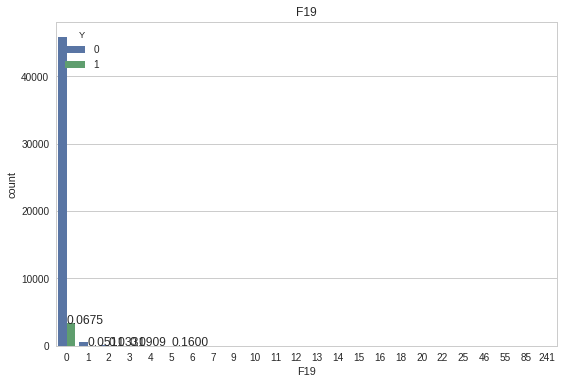

count    49998.000000
mean        -0.000434
std          0.994318
min         -0.057899
25%         -0.057899
50%         -0.057899
75%         -0.057899
max         23.357325
Name: F2, dtype: float64


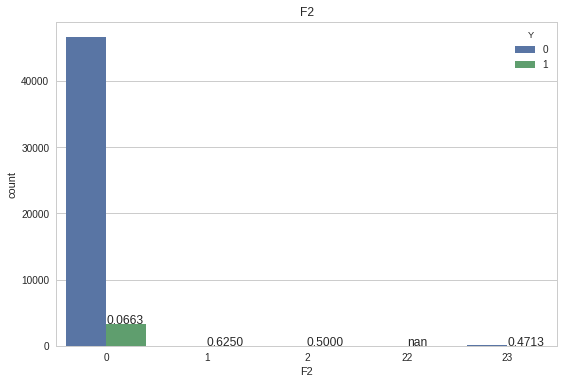

count    49998.000000
mean         0.000527
std          0.997022
min         -1.643950
25%         -0.670499
50%         -0.086429
75%          0.497642
max          9.648080
Name: F22, dtype: float64


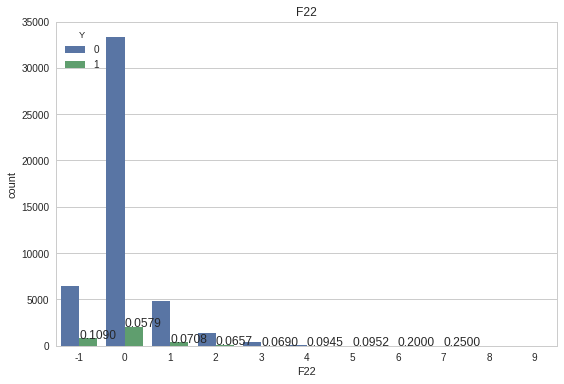

count    49998.000000
mean        -0.002822
std          0.858275
min         -0.022978
25%         -0.022862
50%         -0.022387
75%         -0.020856
max        111.251468
Name: F23, dtype: float64


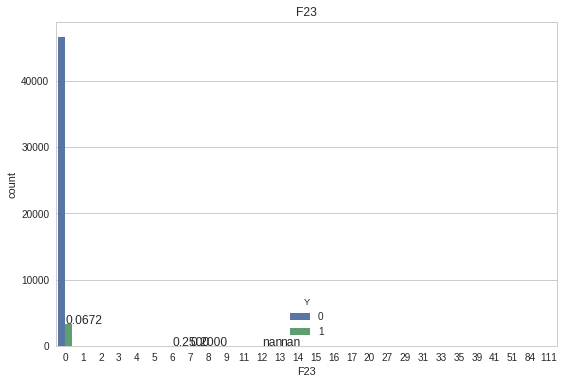

count    49998.000000
mean         0.000054
std          0.994600
min         -0.100266
25%         -0.100266
50%         -0.100266
75%         -0.100266
max         23.107929
Name: F25, dtype: float64


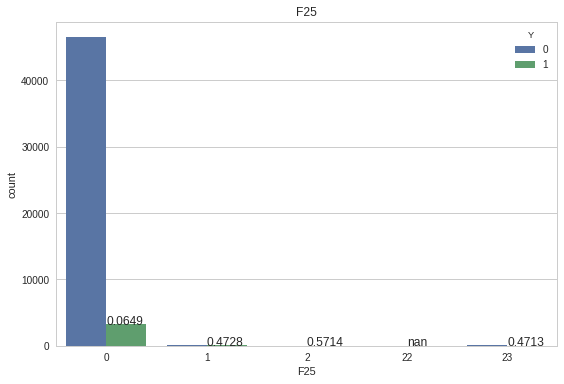

count    49998.000000
mean         0.002940
std          1.045415
min         -0.168135
25%         -0.168051
50%         -0.167961
75%         -0.167721
max        155.608562
Name: F27, dtype: float64


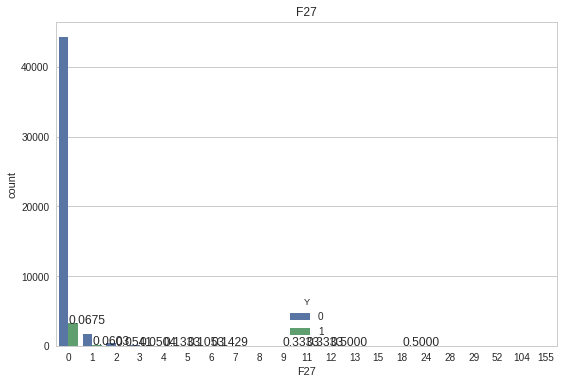

count    49998.000000
mean        -0.002823
std          0.858276
min         -0.024403
25%         -0.022830
50%         -0.022267
75%         -0.020823
max        111.251325
Name: F3, dtype: float64


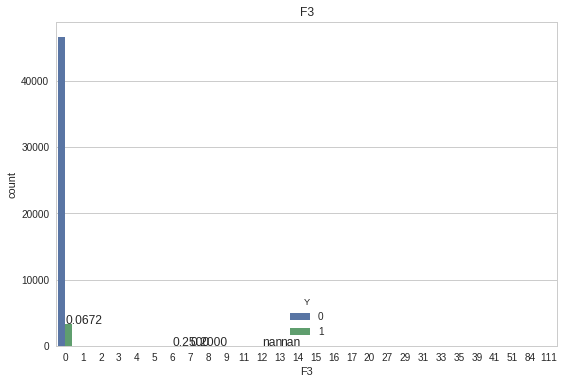

count    49998.000000
mean        -0.003476
std          0.995979
min         -0.665589
25%         -0.665589
50%         -0.665589
75%          0.236019
max          8.350485
Name: F5, dtype: float64


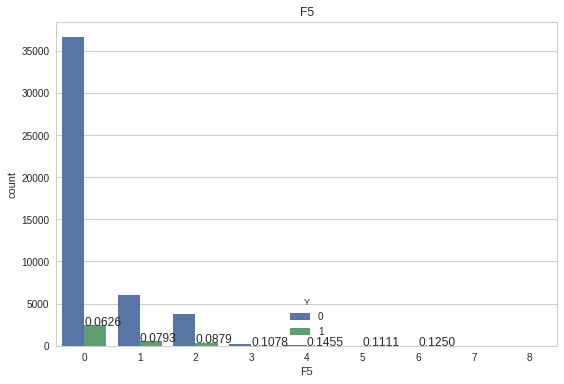

count    49998.000000
mean         0.002028
std          1.004649
min         -0.768919
25%         -0.768919
50%         -0.411917
75%          0.362751
max         10.987860
Name: F6, dtype: float64


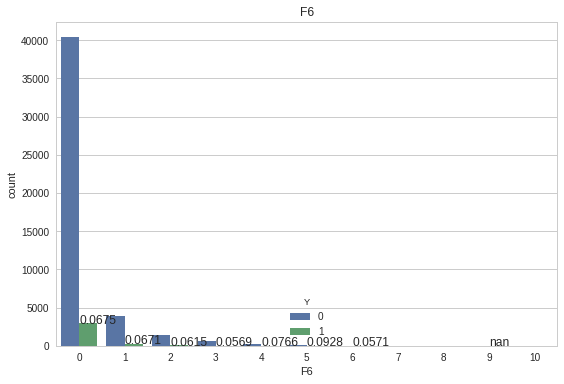

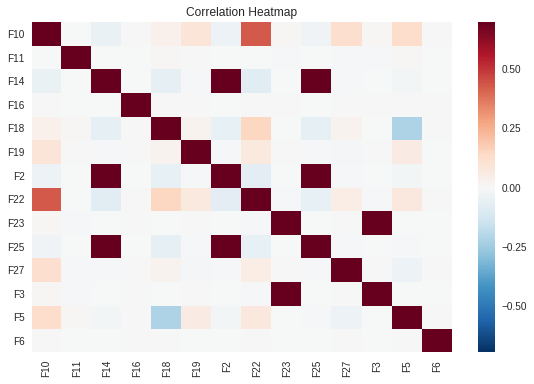

In [26]:
# optional EDA
custom.eda_countplot(xtrain, ytrain)
custom.eda_heatmap(xtrain)
# custom.eda_boxplot(xtrain, ytrain)

# Custom Routines and Implementations  
I implemented my own stacking model.  
Here's a snippet of it.  
For even more custom implementations and routines, check out custom.py  


In [27]:
# Stacked Classifier
# Implements a two level wolpert stacked classifier.
# level1 generalization is trained off generalizations from level 0
# refer to dr. wolpert's famous 1992 paper on stacked generalizations.
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
class StackedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clfs, gen, folds=5):
        self.skf = StratifiedKFold(n_splits=folds, shuffle=True)
        self.clfs = clfs # stacked classifiers
        self.gen = gen # level1 generalizer
        self.folds = folds

    def fit(self, X, y):
        level1, ytest = self.level1_set(X, y)
        self.gen.fit(level1, ytest)
        self.level1 = level1
        return self

    def predict_proba(self, X):
        # predict level 0
        level1 = pd.DataFrame()
        for clf in self.clfs:
            clf_pred = pd.DataFrame(clf.predict_proba(X.values)[:, 1])
            level1 = pd.concat([level1, clf_pred], axis=1, ignore_index=True)
        
        self.level1 = level1
        return self.gen.predict_proba(level1)

    def predict(self, X):
        # predict level 0
        level1 = pd.DataFrame()
        for clf in self.clfs:
            clf_pred = pd.DataFrame(clf.predict_proba(X.values)[:, 1])
            level1 = pd.concat([level1, clf_pred], axis=1, ignore_index=True)

        self.level1 = level1
        return self.gen.predict(level1)
    
    def grid_search(self, gen_grid, X, y):
        ytest = pd.DataFrame()
        level1 = pd.DataFrame()
        for train_index, test_index in self.skf.split(X, y):
            # print train_index, "\n", test_index
            xtrain, xtest = X.iloc[train_index, :], X.iloc[test_index, :]
            ytrain = y.iloc[train_index]
            ytest = pd.concat([ytest, pd.Series(y.iloc[test_index])], axis=0, ignore_index=True)
            
            # train level 0
            level0 = pd.DataFrame()
            for clf in self.clfs:
                clf.fit(xtrain.values, ytrain.values)
                clf_pred = pd.DataFrame(clf.predict_proba(xtest.values)[:, 1])
                level0 = pd.concat([level0, clf_pred], axis=1, ignore_index=True)

            level1 = pd.concat([level1, level0], axis=0, ignore_index=True)
            
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV(self.gen, gen_grid, cv=7, verbose=1500, scoring="roc_auc")
        grid_search.fit(level1, ytest.values.ravel())
        return grid_search

    def level1_set(self, X, y):
        k = 1 # fold tracker
        ytest = pd.DataFrame()
        level1 = pd.DataFrame()
        for train_index, test_index in self.skf.split(X, y):
            # print train_index, "\n", test_index
            xtrain, xtest = X.iloc[train_index, :], X.iloc[test_index, :]
            ytrain = y.iloc[train_index]
            ytest = pd.concat([ytest, pd.Series(y.iloc[test_index])], axis=0, ignore_index=True)
            
            # train level 0
            j = 0 # model tracker
            level0 = pd.DataFrame()
            for clf in self.clfs:
                print "round(%d): fitting model %d..." % (k, j)
                clf.fit(xtrain.values, ytrain.values)
                clf_pred = pd.DataFrame(clf.predict_proba(xtest.values)[:, 1])
                level0 = pd.concat([level0, clf_pred], axis=1, ignore_index=True)
                j += 1

            level1 = pd.concat([level1, level0], axis=0, ignore_index=True)
            k += 1
            
        return (level1, ytest.values.ravel())


    def heatmap(self):
        level1 = pd.DataFrame(self.level1)
        ax = sns.heatmap(level1.corr(), vmin=-1.0, vmax=1.0, annot=True, fmt=".2f")
        ax.set_title("Stacking Correlation Heatmap (level1)")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.tight_layout()
        plt.show()
        plt.close()

# Final Remarks  
I learned a lot from this competition.  
A lot of exploratory data analysis was done.  
Some of it helped and some if it didn't.  
A lot of different models were tried.  
Some of them worked, and some of them didn't.  
In the end, I'm interested in trying some of the things I learned on new kaggle competitions in the future.  

## What worked:  
* Feature Selection (27 down to 14 features)  
* Scaling (log two of the exponential features. scale the rest)  
* XGBoost and XGBoost Stacking  
* RandomForest and ExtraRandomForest  
* Median Imputation  

## What didn't work:
* Neural Networks alone.  
* Stacking Random Forests  
* Under / Over sampling  
* Unskewing data  
* Dropping features based on correlation and F score  
* Dropping high leverage points  
* much much more (too much to list here)  
